<a href="https://colab.research.google.com/github/Vecheslav-Eremeev/sklearn_projects/blob/main/Titanic_save_humans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание. Титаник
В этом домашнем задании вам предлагается решить задачу предсказания выживших пассажиров Титаника. Эту задачу машинного обучения рано или поздно решает, наверное, любой, кто обучается анализу данных. Информация о датасете доступна по <a href=https://www.kaggle.com/c/titanic>ссылке</a>.

Кстати, здесь же есть много готовых решений нашей задачи. Решение можно посмотреть в разделе <a href=https://www.kaggle.com/c/titanic/code>code на kaggle</a>.

Некоторые решения, которые уже есть:
https://www.kaggle.com/hacktech33/titanic-solution-xgboost (простое решение)

https://www.kaggle.com/shrutijhaa/in-top-3-titanic-machine-learning-from-disaster (возможно, слишком много визуализации, но хорошее качество)

https://www.kaggle.com/blackhurt/top-3-using-voting-classifier (сильное решение, использует метод простого голосования трёх сильных моделей)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Загрузка данных

Загрузим датасет Titanic из приложенных файлов. В первом файле находится информация о пассажирах, во втором -- информация о том, выжил пассажир или нет.

Если вы запускаете ноутбук на Google Colab, самым простым способом загрузить данные в ноутбук будет примонтировать к Colab ваш Google Drive. Для этого сначала положите в свою корневую директорию Google Drive  файлы, приложенные к этому ноутбуку, а затем выполните три закоментированные строчки в клетке ниже. <a href=https://www.machinelearningmastery.ru/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166/>Подробная инструкция по работе с Google Drive + Google Colab</a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
data = pd.read_csv('/content/gdrive/MyDrive/titanic_data.csv')

#Если запускаете ноутбук локально:
#data = pd.read_csv('titanic_data.csv', index_col='PassengerId')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
basic_features = data.columns

y = pd.read_csv('/content/gdrive/MyDrive/titanic_surv.csv')
y.index = data.index

print(f'Всего {len(data)} пассажиров в выборке')
data.head()

Всего 891 пассажиров в выборке


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [ ]:
data = data.join(y)
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


## Исследование датасета

### Задание 1 (1 балл)
Опишите датасет. Сколько в нём мужчин, сколько женщин? Посчитайте распределение по классам пассажиров. Используйте функцию ``pd.Series.value_counts``. <a href=https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html>Пример использования</a>

Посчитайте долю выживших мужчин к общему количеству мужчин, а также женщин к общему количеству женщин. Сделайте выводы. 
Проведите схожую аналитику по возрасту выживших и по классу выживших. 

Вам поможет функция ``plt.hist()``. <a href=https://matplotlib.org/3.3.1/gallery/pyplots/pyplot_text.html#sphx-glr-gallery-pyplots-pyplot-text-py> Пример использования </a> 

In [ ]:
data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

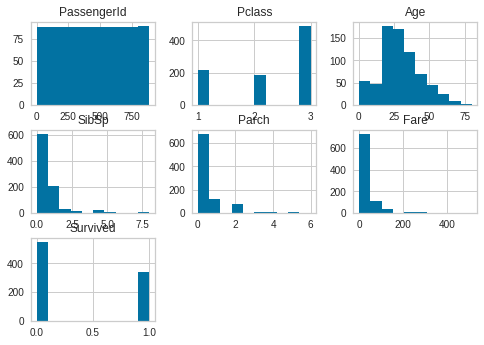

In [ ]:
data.hist();

## Заполнение пропусков в данных
В данных имеются пропуски в трёх колонках: 

In [ ]:
data.columns[data.isna().any()].tolist()

['Age', 'Cabin', 'Embarked']

Для простоты заполним все пропуски в категориальных колонках новым классом "0", а в числовой колонке Age --- медианным значением. 

In [ ]:
data.loc[:, ['Cabin', 'Embarked']] = data.loc[:, ['Cabin', 'Embarked']].fillna('0')
data['Age'] = data['Age'].fillna(data['Age'].median())

## Подготовка плана тестирования

### Задание 2. (0 баллов)
Разделите выборку на обучающее и тестовое множество в соотношении 70:30.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data.drop('Survived', axis=1), y, random_state=42, test_size=0.3)

## Выделение новых признаков
Теперь отложим тестовые данные и приступим к моделированию. Внимательно изучите данные. Можете ли вы выделить признаки, которые не указаны явно в таблице?

### Задание 3 (1 балл)
 Сформируйте по крайней мере один новый признак и объясните ваш выбор. Пример признака сформирован за вас. 

Указания: 
- Пассажиров можно поделить на несколько классов по их именам.
- Различных номеров кают слишком много. Но буквы в номерах кают указывают на их местоположение. (***Этот признак сформирован в примере***)
- Возможно, имеет смысл отделить мальчиков от мужчин. Отделять девочек от женщин может быть не так важно
- Другие идеи для признаков можно почерпнуть на форуме в обсуждении задачи на kaggle.com.

In [ ]:
data.tail(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,0,S,0
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S,1
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.45,0,S,0
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,1
890,891,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,0,Q,0


In [ ]:
data['Cabin'][:10]

0       0
1     C85
2       0
3    C123
4       0
5       0
6     E46
7       0
8       0
9       0
Name: Cabin, dtype: object

In [ ]:
def get_cabin_letter(row):
    return row['Cabin'][0]

data_full = data.copy()
data_full['cabin_type'] = data.apply(get_cabin_letter, axis=1)

Сюда добавьте описание вашего нового признака

In [ ]:
def get_family(row):
  return row['SibSp'] + row['Parch']

data_full['Family'] = data.apply(get_family, axis=1)

In [ ]:
data_full.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,cabin_type,Family
369,370,1,"Aubart, Mme. Leontine Pauline",female,24.0,0,0,PC 17477,69.3000,B35,C,1,B,0
296,297,3,"Hanna, Mr. Mansour",male,23.5,0,0,2693,7.2292,0,C,0,0,0
466,467,2,"Campbell, Mr. William",male,28.0,0,0,239853,0.0000,0,S,0,0,0
866,867,2,"Duran y More, Miss. Asuncion",female,27.0,1,0,SC/PARIS 2149,13.8583,0,C,1,0,1
204,205,3,"Cohen, Mr. Gurshon ""Gus""",male,18.0,0,0,A/5 3540,8.0500,0,S,1,0,0


In [ ]:
drop_cols = 'PassengerId Name Ticket Cabin'.split()
data = data.drop(drop_cols, axis=1)
data_full = data_full.drop(drop_cols, axis=1)

## Кодирование категориальных признаков и обработка данных
Все признаки сейчас делятся на числовые, бинарные, категориальные и текстовые. К текстовым признакам можно отнести имя пассажира, номер билета и номер каюты: значения этих признаков уникальны почти для всех пассажиров, и простого способа использовать их в модели не существует.

### Задание 4 (0 баллов)
Пока используя только изначальные признаки, перекодируйте категориальные признаки функцией ``pd.get_dummies``. Естественно, имена пассажиров и номера билетов и кают кодировать не стоит, поскольку все значения этих признаков уникальные. 

In [ ]:
X = pd.get_dummies(data.drop('Survived', axis=1))
X.head(3)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_0,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,0,1
1,1,38.0,1,0,71.2833,1,0,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,0,1


## Обучение baseline-модели

### Задание 5 (1 балл)

Обучите одну из простых известных вам моделей. Измерьте качество полученной модели на кросс-валидации (используйте только обучающую выборку!)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

In [ ]:
num_folds = 10
n_estimators = 100
random_seed = 42

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=random_seed, test_size=0.3)

In [ ]:
kfold = KFold(n_splits=num_folds, random_state=random_seed, shuffle=True)
cv_results = cross_val_score(GaussianNB(), X_train, y_train, cv=kfold)
cv_results

array([0.73015873, 0.79365079, 0.74603175, 0.75806452, 0.74193548,
       0.74193548, 0.74193548, 0.64516129, 0.72580645, 0.67741935])

In [ ]:
cv_results.mean()

0.7302099334357399

### Задание 6 (1 балл)
Добавьте в модель два новых сгенерированных признака. Если нужно, добавьте признаки, сгенерированные ohe-hot кодированием. Обучите ту же самую модель на расширенном множестве признаков. Улучшилось ли качество предсказания на кросс-валидации?

In [ ]:
X = pd.get_dummies(data_full.drop('Survived', axis=1), drop_first=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.3)

kfold = KFold(n_splits=num_folds, random_state=random_seed, shuffle=True)
cv_results = cross_val_score(GaussianNB(), X_train, y_train, cv=kfold)
cv_results

array([0.73015873, 0.65079365, 0.76190476, 0.72580645, 0.4516129 ,
       0.67741935, 0.79032258, 0.72580645, 0.77419355, 0.79032258])

In [ ]:
cv_results.mean()

0.7078341013824885

## Дополнительное моделирование
### Задание 7 (2 балла)
Теперь более серьёзно подойдём к моделированию. Попробуйте несколько алгоритмов из тех, что мы проходили в курсе. Вам помогут ноутбуки с линейными алгоритмами и выбором модели. Хотя бы для одного алгоритма проведите подбор оптимального гиперпараметра. 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [ ]:
kfold = KFold(n_splits=num_folds, random_state=random_seed, shuffle=True)
cv_results = cross_val_score(LogisticRegression(), X_train, y_train, cv=kfold)
cv_results

array([0.80952381, 0.79365079, 0.74603175, 0.79032258, 0.77419355,
       0.72580645, 0.83870968, 0.80645161, 0.88709677, 0.75806452])

In [ ]:
cv_results.mean()

0.7929851510496672

In [ ]:
kfold = KFold(n_splits=num_folds, random_state=random_seed, shuffle=True)
cv_results = cross_val_score(RandomForestClassifier(), X_train, y_train, cv=kfold)
cv_results

array([0.82539683, 0.80952381, 0.84126984, 0.77419355, 0.85483871,
       0.77419355, 0.77419355, 0.82258065, 0.88709677, 0.75806452])

In [ ]:
cv_results.mean()

0.8121351766513056

In [ ]:
kfold = KFold(n_splits=num_folds, random_state=random_seed, shuffle=True)
cv_results = cross_val_score(LinearSVC(), X_train, y_train, cv=kfold)
cv_results

array([0.76190476, 0.65079365, 0.71428571, 0.75806452, 0.74193548,
       0.77419355, 0.74193548, 0.5483871 , 0.79032258, 0.77419355])

In [ ]:
cv_results.mean()

0.7256016385048643

In [ ]:
from yellowbrick.model_selection import ValidationCurve

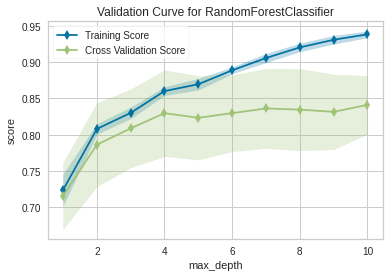

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
vc = ValidationCurve(
    RandomForestClassifier(n_estimators=n_estimators),
    param_name='max_depth',
    param_range=np.arange(1,11),
    cv=10,
    n_jobs=-1
)
vc.fit(X_train, y_train)
vc.poof();

## Результаты моделирования

### Задание 8 (1 балл)
Измерьте качество итоговой модели на кросс-валидации. Выполните предсказание на тестовом множестве и сохраните их в переменную ``y_test``. Измерьте итоговое качество на тестовом множестве.

In [ ]:
kfold = KFold(n_splits=num_folds, random_state=random_seed, shuffle=True)
cv_results = cross_val_score(RandomForestClassifier(n_estimators=n_estimators, max_depth=7), 
                             X_train, y_train, cv=kfold)
cv_results

array([0.85714286, 0.85714286, 0.82539683, 0.83870968, 0.87096774,
       0.77419355, 0.79032258, 0.80645161, 0.88709677, 0.83870968])

In [ ]:
cv_results.mean()

0.8346134152585764

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
model = RandomForestClassifier(n_estimators=n_estimators, max_depth=7)
model.fit(X_train, y_train)
y_test = model.predict(X_val)

In [ ]:
accuracy_score(y_val, y_test)

0.8208955223880597

## Выводы
### Задание 9 (3 балла)
Сделайте выводы. Какие из идей сработали? Какие оказались лишними?

Добавление новых параметров не улычшило предсказание модели.
Family и Cabin_type были не нужны.